# Library

In [1]:
import astropy_healpix as ah
import numpy as np
from astropy.table import Table

from astropy.coordinates import SkyCoord
from ligo.skymap.io.fits import read_sky_map
from ligo.skymap.postprocess import crossmatch
from astropy import units as u

In [2]:
#	Append the path to the GECKO project root directory
import sys
sys.path.append('..')
from config.config import *
from src.AlertReceiver import *
from src.GeckoHelper import *
from util.util import *

In [3]:
#	plot setting
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')

# 1. Receive the GW alert

- Online Test

In [4]:
#	Online Test
# consumer = Consumer(client_id=GCN_KAFKA_CONFIG['client_id'], client_secret=GCN_KAFKA_CONFIG['client_secret'],)
# consumer.subscribe(['igwn.gwalert'])

# while True:
#     for message in consumer.consume():
#         AlertReceiver(message.value())

- Manual Test

In [5]:
#	Offline Test
# with open('../data/MS181101ab-preliminary.json', 'r') as f:
# with open('../data/MS181101ab-earlywarning.json', 'r') as f:
# with open('../data/MS181101ab-ext-update.json', 'r') as f:
with open('../data/MS181101ab-initial.json', 'r') as f:
    record = f.read()

record, skymap = AlertReceiver(record)

EVENT: MS181101ab-INITIAL
Most probable sky location (RA, Dec) = (194.304, -17.857)
Distance = 39.8 +/- 8.3 Mpc
------------------------------------------------------------
Record:
{'alert_type': 'INITIAL',
 'area_90': 30.975181093574633,
 'decmax': -17.856895095545468,
 'distmean': 39.76999609489013,
 'diststd': 8.308435058808886,
 'event': {'central_frequency': None,
           'classification': {'BBH': 0.03,
                              'BNS': 0.95,
                              'NSBH': 0.01,
                              'Terrestrial': 0.01},
           'duration': None,
           'far': 9.11069936486e-14,
           'group': 'CBC',
           'instruments': ['H1', 'L1', 'V1'],
           'pipeline': 'gstlal',
           'properties': {'HasMassGap': 0.01,
                          'HasNS': 0.95,
                          'HasRemnant': 0.91},
           'search': 'MDC',
           'significant': True,
           'skymap': 'U0lNUExFICA9ICAgICAgICAgICAgICAgICAgICBUIC8gY29uZm9ybXMgdG

- Path

In [6]:
path_output = f"../output/{record['superevent_id']}_{record['alert_type']}"

# 2. Check a Singnificance

- Initialize the variables for trigger

In [7]:
gecko_digestor_trigger = False
em_counterpart = False
confidence_limit = 0.0 # 0-1 [%]
obs_request_day = 0
# gecko_priority: int = 0

- Alert type
	- EARLYWARNING,PRELIMINARY,INITIAL,UPDATE,RETRACTION
- Significant
	- true if trials factor × FAR < 1/month for CBC events, otherwise false
	- true if trials factor × FAR < 1/year for burst events, otherwise false

In [8]:
if record['event']['significant']:
	if record['alert_type'] in ['EARLYWARNING','PRELIMINARY','INITIAL','UPDATE','RETRACTION']:
		#============================================================
		#	Designated alert type
		#============================================================
		#	No GECKO Digestor Trigger
		#------------------------------------------------------------
		#	Early warning
		if record['alert_type'] == 'EARLYWARNING':
			gecko_digestor_trigger = False
			# confidence_limit = 0.9 # 0-1 [%]
			obs_request_day = 1
			print("This is an EARLYWARNING alert, stay tuned!")
		#	Preliminary
		elif record['alert_type'] == 'PRELIMINARY':
			gecko_digestor_trigger = True
			confidence_limit = 0.9 # 0-1 [%]
			obs_request_day = 1
		#    Initial
		elif record['alert_type'] == 'INITIAL':
			gecko_digestor_trigger = True
			confidence_limit = 0.9 # 0-1 [%]
			obs_request_day = 3
		#    Update
		elif record['alert_type'] == 'UPDATE':
			gecko_digestor_trigger = True
			confidence_limit = 0.9 # 0-1 [%]
			obs_request_day = 3
		#	Retraction
		elif record['alert_type'] == 'RETRACTION':
			print("This is a RETRACTION alert, OH COME ON!")
else:
	print("This is a NON-SIGNIFICANT alert")

print(f"{record['alert_type']} event detected")
if gecko_digestor_trigger:
	print(f"--> Initiate GECKO Digestor Trigger")
	print(f"--> Set confidence limit to {confidence_limit*1e2:.1f}%")

INITIAL event detected
--> Initiate GECKO Digestor Trigger
--> Set confidence limit to 90.0%


{'BNS': 0.95, 'NSBH': 0.01, 'BBH': 0.03, 'Terrestrial': 0.01}
 {'HasNS': 0.95, 'HasRemnant': 0.91, 'HasMassGap': 0.01}

In [9]:
most_probable_event = max(record['event']['classification'], key=record['event']['classification'].get)
most_probable_event_prob = record['event']['classification'][most_probable_event]

#   Yes EM counterpart
if most_probable_event in ['BNS', 'NSBH',]:
    #   Possibilities to have an emission
    if (record['event']['properties']['HasNS']>0.9) & (record['event']['properties']['HasRemnant']>0.9):
        em_counterpart = True
elif most_probable_event in ['BBH']:
    pass
elif most_probable_event in ['Terrestrial']:
    gecko_digestor_trigger = False
    pass
print(f"Most probable event: {most_probable_event} ({most_probable_event_prob*1e2:.1f}%)")
print(f"Gecko Digestor Trigger: {gecko_digestor_trigger}")

Most probable event: BNS (95.0%)
Gecko Digestor Trigger: True


- Check the existence of an `external_coinc`

In [10]:
if record['external_coinc'] != None:
	skymap_str = record['external_coinc']['combined_skymap']
	skymap = read_skymap_bytes_to_table(skymap_str)
	print(f"{record['external_coinc']['search']} by {record['external_coinc']['observatory']} (t=t0+{record['external_coinc']['time_difference']} sec)")
else:
	print(f"No external_coinc")

No external_coinc


### Skymap Analysis

In [11]:
skymap['RA'] = 0.0
skymap['DEC'] = 0.0

for i in np.arange(len(skymap)):
	uniq = skymap[i]['UNIQ']
	level, ipix = ah.uniq_to_level_ipix(uniq)
	nside = ah.level_to_nside(level)
	ra, dec = ah.healpix_to_lonlat(ipix, nside, order='nested')

	skymap['RA'][i] = ra.deg
	skymap['DEC'][i] = dec.deg

- Area within confidence region

In [12]:
skymap.sort('PROBDENSITY', reverse=True)
level, ipix = ah.uniq_to_level_ipix(skymap['UNIQ'])
pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level))
prob = pixel_area * skymap['PROBDENSITY']
cumprob = np.cumsum(prob)
i = cumprob.searchsorted(confidence_limit)
area_90 = pixel_area[:i].sum()
#	New column about cumulative probability
skymap['CUMPROBDENSITY'] = cumprob

print(f"{area_90.to_value(u.deg**2):1.3f} deg2 ({confidence_limit*1e2:.1f} %)")

30.975 deg2 (90.0 %)


In [13]:
ramin, ramax = np.min(skymap['RA'][cumprob<confidence_limit]), np.max(skymap['RA'][cumprob<confidence_limit])
decmin, decmax = np.min(skymap['DEC'][cumprob<confidence_limit]), np.max(skymap['DEC'][cumprob<confidence_limit])

print(f"RA ranges: {ramin:.3f}~{ramax:.3f} deg")
print(f"DEC ranges: {decmin:.3f}~{decmax:.3f} deg")

RA ranges: 191.074~199.248 deg
DEC ranges: -27.448~-12.330 deg


- Check distance and most probable sky location
- Meta data from skymap

In [14]:
level, ipix = ah.uniq_to_level_ipix(
	skymap[np.argmax(skymap['PROBDENSITY'])]['UNIQ']
)
ra, dec = ah.healpix_to_lonlat(ipix, ah.level_to_nside(level),
								order='nested')
print(f'Most probable sky location (RA, Dec) = ({ra.deg:.3f}, {dec.deg:.3f})')

# Print some information from FITS header
distmean, diststd = skymap.meta['DISTMEAN'], skymap.meta['DISTSTD']
print(f'Distance = {distmean:.3f} +/- {diststd:.3f} Mpc')

Most probable sky location (RA, Dec) = (194.304, -17.857)
Distance = 39.770 +/- 8.308 Mpc


# 3. Catalog Matching

- Read GLADE+ catalog (.fits for the faster I/O)

### Read & Matching

In [15]:
'''- 1	GLADE no	GLADE+ catalog number
- 2	PGC no	Principal Galaxies Catalogue number
- 3	GWGC name	Name in the GWGC catalog
- 4	HyperLEDA name	Name in the HyperLEDA catalog
- 5	2MASS name	Name in the 2MASS XSC catalog
- 6	WISExSCOS name	Name in the WISExSuperCOSMOS catalog (wiseX)
- 7	SDSS-DR16Q name	Name in the SDSS-DR16Q catalog
- 8	Object type flag
	- Q: the source is from the SDSS-DR16Q catalog
	- G:the source is from another catalog and has not been identified as a quasar
- 9	RA	Right ascension in degrees
- 10	Dec	Declination in degrees
- 11	B	Apparent B magnitude
- 12	B_err	Absolute error of apparent B magnitude
- 13	B flag
	- 0: the B magnitude is measured
	- 1: the B magnitude is calculated from the B_J magnitude
- 14	B_Abs	Absolute B magnitude
- 15	J	Apparent J magnitude
- 16	J_err	Absolute error of apparent J magnitude
- 17	H	Apparent H magnitude
- 18	H_err	Absolute error of apparent H magnitude
- 19	K	Apparent K_s magnitude
- 20	K_err	Absolute error of apparent K_s magnitude
- 21	W1	Apparent W1 magnitude
- 22	W1_err	Absolute error of apparent W1 magnitude
- 23	W2	Apparent W2 magnitude
- 24	W2_err	Absolute error of apparent W2 magnitude
- 25	W1 flag
	- 0: the W1 magnitude is measured
	- 1: the W1 magnitude is calculated from the K_s magnitude
- 26	B_J	Apparent B_J magnitude
- 27	B_J err	Absolute error of apparent B_J magnitude
- 28	z_helio	Redshift in the heliocentric frame
- 29	z_cmb	Redshift converted to the Cosmic Microwave Background (CMB) frame
- 30	z flag
	- 0: the CMB frame redshift and luminosity distance values given in columns 29 and 33 are not corrected for the peculiar velocity
	- 1: they are corrected values
- 31	v_err	Error of redshift from the peculiar velocity estimation
- 32	z_err	Measurement error of heliocentric redshift
- 33	d_L	Luminosity distance in Mpc units
- 34	d_L err	Error of luminosity distance in Mpc units
- 35	dist flag
	- 0: the galaxy has no measured redshift or distance value
	- 1: it has a measured photometric redshift from which we have calculated its luminosity distance
	- 2: it has a measured luminosity distance value from which we have calculated its redshift
	- 3: it has a measured spectroscopic redshift from which we have calculated its luminosity distance
- 36	M*	Stellar mass in 10^10 M_Sun units
- 37	M*_err	Absolute error of stellar mass in 10^10 M_Sun units
- 38	M* flag
	- 0: if the stellar mass was calculated assuming no active star formation
	- 1: if the stellar mass was calculated assuming active star formation
- 39	Merger rate	Base-10 logarithm of estimated BNS merger rate in the galaxy in Gyr^-1 units
- 40	Merger rate error	Absolute error of estimated BNS merger rate in the galaxy'''

'- 1\tGLADE no\tGLADE+ catalog number\n- 2\tPGC no\tPrincipal Galaxies Catalogue number\n- 3\tGWGC name\tName in the GWGC catalog\n- 4\tHyperLEDA name\tName in the HyperLEDA catalog\n- 5\t2MASS name\tName in the 2MASS XSC catalog\n- 6\tWISExSCOS name\tName in the WISExSuperCOSMOS catalog (wiseX)\n- 7\tSDSS-DR16Q name\tName in the SDSS-DR16Q catalog\n- 8\tObject type flag\n\t- Q: the source is from the SDSS-DR16Q catalog\n\t- G:the source is from another catalog and has not been identified as a quasar\n- 9\tRA\tRight ascension in degrees\n- 10\tDec\tDeclination in degrees\n- 11\tB\tApparent B magnitude\n- 12\tB_err\tAbsolute error of apparent B magnitude\n- 13\tB flag\n\t- 0: the B magnitude is measured\n\t- 1: the B magnitude is calculated from the B_J magnitude\n- 14\tB_Abs\tAbsolute B magnitude\n- 15\tJ\tApparent J magnitude\n- 16\tJ_err\tAbsolute error of apparent J magnitude\n- 17\tH\tApparent H magnitude\n- 18\tH_err\tAbsolute error of apparent H magnitude\n- 19\tK\tApparent K_s m

In [16]:
try:
	cat
except NameError:
	# cat = Table.read('../data/GLADE+.fits', format='fits', memmap=True)
	# cat = Table.read('../data/GLADE+.fits', memmap=True)
	cat = Table.read('../data/GLADE+_230419.fits', format='fits',)
	
	coordinates = SkyCoord(cat['col9']*u.deg, cat['col10']*u.deg, cat['col33']*u.Mpc)

In [17]:
result = crossmatch(skymap, coordinates, contours=(0.5, 0.9))
cat['searched_prob_vol'] = result.searched_prob_vol
# cat['probdensity_vol'] = result.probdensity_vol
cat['prob_vol'] = result.probdensity_vol

In [18]:
indx_vol90 = np.where(cat['searched_prob_vol']<confidence_limit)
select_cat = cat[indx_vol90]
#	Stellar mass
select_cat['stellar_mass'] = select_cat['col36']
select_cat['flag_stmass'] = ~select_cat['col36'].mask
select_cat['stellar_mass'][select_cat['col36'].mask] = np.min(select_cat['col36'])
#	Extra probability
select_cat['prob_vol_x_stmass'] = min_max_normalize(select_cat['stellar_mass']*select_cat['prob_vol'])

In [19]:
#	Key to sort the candidate
# probkey = "prob_vol"
probkey = "prob_vol_x_stmass"

- LIGHT version of Catalog

In [20]:
simple_galcat = Table()
simple_galcat['name'] = select_cat['col1']
simple_galcat['ra'] = select_cat['col9']
simple_galcat['dec'] = select_cat['col10']
simple_galcat['d_L'] = select_cat['col33']
simple_galcat['prob_vol'] = select_cat['prob_vol']
simple_galcat['stmass'] = select_cat['stellar_mass']
simple_galcat[probkey] = select_cat[probkey]
#	Sort by prob --> rank
simple_galcat = simple_galcat[np.flipud(np.argsort(simple_galcat[probkey]))]
simple_galcat['rank'] = np.arange(len(simple_galcat), dtype=int)
#   Formatting
for key in simple_galcat.keys():
    if key in ['ra', 'dec', 'd_L', probkey]:
        simple_galcat[key].format = '.3f'
#   Cumulative Probability
cumsum_prob_gal = np.cumsum(simple_galcat[probkey])
sum_prob_gal = np.sum(simple_galcat[probkey])

simple_galcat['confidence'] = 0.0
simple_galcat['confidence'][np.max(cumsum_prob_gal)*1.0>=cumsum_prob_gal] = 1.0
simple_galcat['confidence'][np.max(cumsum_prob_gal)*0.95>=cumsum_prob_gal] = 0.95
simple_galcat['confidence'][np.max(cumsum_prob_gal)*0.9>=cumsum_prob_gal] = 0.9
simple_galcat['confidence'][np.max(cumsum_prob_gal)*0.5>=cumsum_prob_gal] = 0.5

simple_galcat['obj'] = record['superevent_id']
simple_galcat['note'] = simple_galcat['name']
#   Meta data
galcat_meta_dict = {
    'superevent_id': record['superevent_id'],
    'alert_type': record['alert_type'],
    'most_probable_event': most_probable_event,
    'most_probable_event_prob': most_probable_event_prob,
    'confidence': confidence_limit,
    'ordering': probkey
}
simple_galcat.meta = galcat_meta_dict

simple_galcat_name = f"{path_output}/HostGalaxyCatalog_{confidence_limit*1e2:g}.csv"
simple_galcat.write(simple_galcat_name, format='csv', overwrite=True)
print(f"Save the host galaxy candidate catalog ({os.path.basename(simple_galcat_name)})")

Save the host galaxy candidate catalog (HostGalaxyCatalog_90.csv)


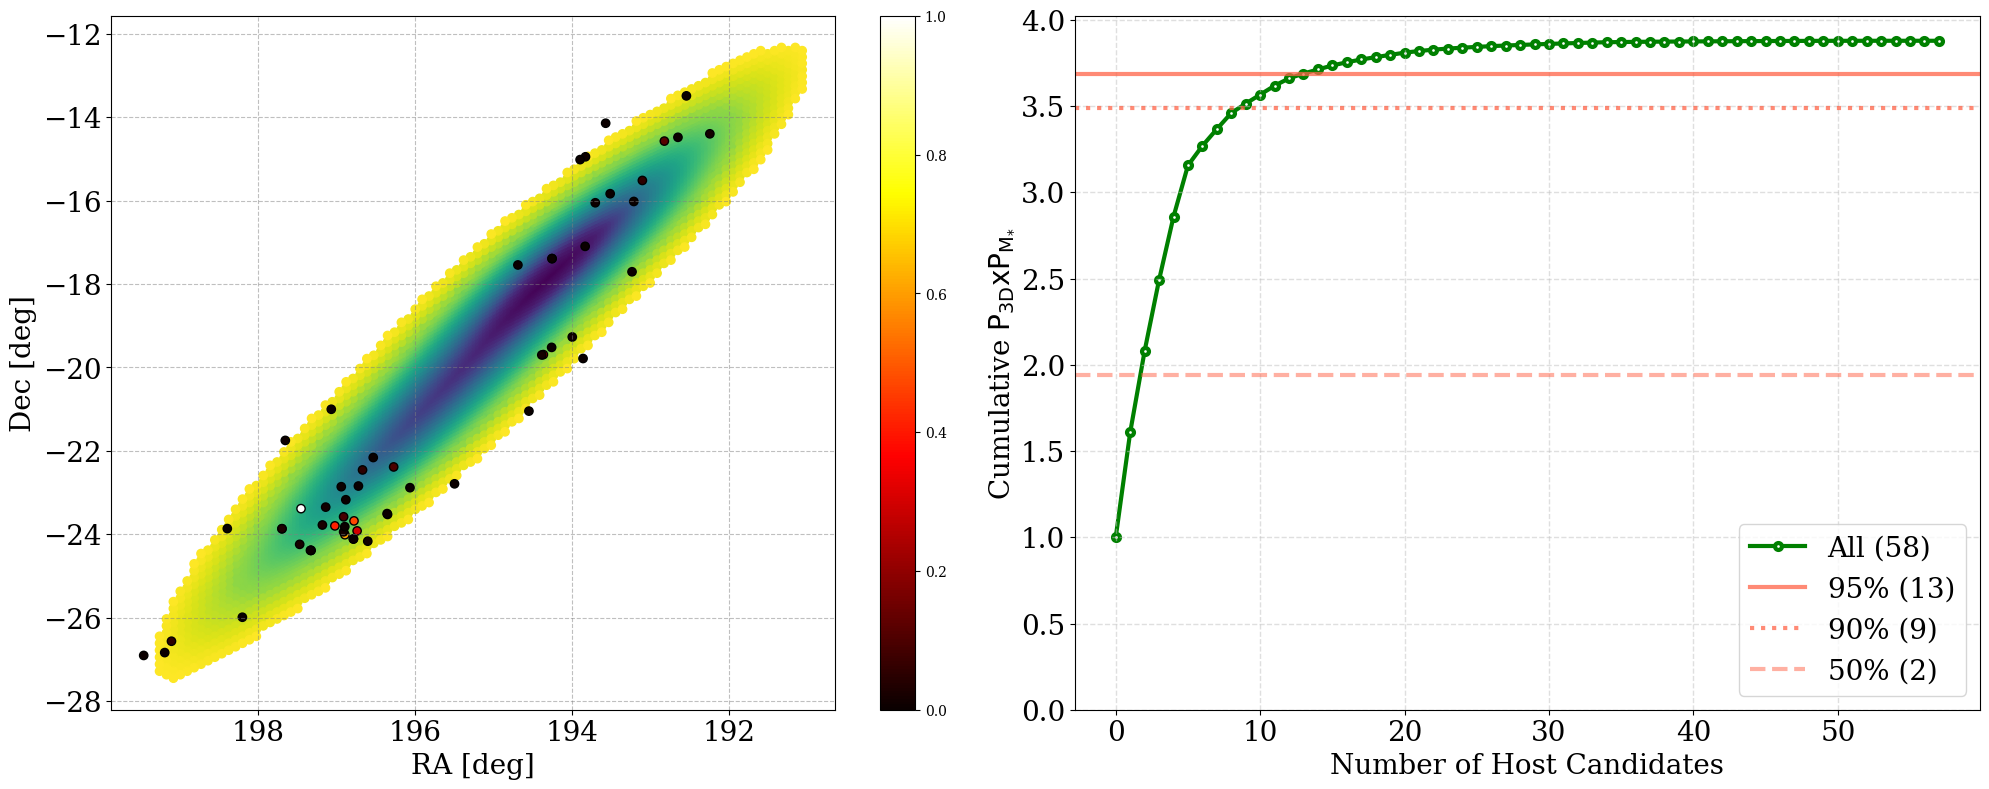

In [21]:
fig = plt.figure(figsize=(20, 8))

plt.subplot(121)

plt.scatter(simple_galcat['ra'], simple_galcat['dec'], c=simple_galcat[probkey], cmap='hot', edgecolors='k')
cbar_gal = plt.colorbar()

plt.scatter(skymap['RA'][cumprob<0.9], skymap['DEC'][cumprob<0.9], c=skymap['CUMPROBDENSITY'][cumprob<0.9], zorder=0)
xl, xr = plt.xlim()
# cbar = plt.colorbar()

plt.grid('both', ls='--', c='grey', alpha=0.5)
plt.xlim([xr, xl])
plt.xlabel('RA [deg]', fontsize=20)
plt.ylabel('Dec [deg]', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.tight_layout()

plt.subplot(122)
plt.plot(cumsum_prob_gal, '.-', mfc='w', mew=3, ms=10, lw=3, c='g', label=f"All ({len(cumsum_prob_gal)})", zorder=0)
plt.axhline(y=0.95*sum_prob_gal, ls='-', c='tomato', lw=3, alpha=0.75, label=f"95% ({len(simple_galcat[simple_galcat['confidence']<=0.95])})")
plt.axhline(y=0.9*sum_prob_gal, ls=':', c='tomato', lw=3, alpha=0.75, label=f"90% ({len(simple_galcat[simple_galcat['confidence']<=0.9])})")
plt.axhline(y=0.5*sum_prob_gal, ls='--', c='tomato', lw=3, alpha=0.5, label=f"50% ({len(simple_galcat[simple_galcat['confidence']<=0.5])})")
plt.xlabel('Number of Host Candidates', fontsize=20)

if probkey == 'prob_vol':
    ylabel = r'Cumulative $\rm P_{3D}$'
elif probkey == 'prob_vol_x_stmass':
	ylabel = r'Cumulative $\rm P_{3D}xP_{M_{*}}$'
plt.ylabel(ylabel)
# plt.ylabel(r'Cumulative $\rm P_{3D}$', fontsize=20)
yl, yu = plt.ylim()
plt.ylim([0, yu])
plt.legend(loc='lower right', fontsize=20)
# _ = plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid('both', color='silver', ls='--', lw=1, alpha=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
# plt.savefig(f"{path_output}/cumulative_p3d_HostGalaxy.png", dpi=100,)


# 4. sky grid matching

In [22]:
# obs = 'KCT'
# obs = 'KMTNet-ks4'
obs = 'KMTNet'
# obs = 'CBNUO'
# obs = 'RASA36'
# obs = '7DT'
pointing_cat = Table.read(f'../data/skygrid/{obs}/displaycenter.txt', format='csv')
pointing_polygon_cat = Table.read(f'../data/skygrid/{obs}/displayfootprint.txt', format='csv')
coordinates = SkyCoord(pointing_cat['ra'], pointing_cat['dec'], unit='deg')

- count the number of pixels within 90% confidence area
	- Full search 3.9s

In [23]:
indx_select_skygrid = count_skymap_within_fov(pointing_polygon_cat, skymap, confidence_limit)
select_pointing_cat = pointing_cat[indx_select_skygrid]
select_pointing_polygon_cat = pointing_polygon_cat[indx_select_skygrid]

from astropy.table import hstack
select_skygrid_cat = hstack([select_pointing_cat, select_pointing_polygon_cat])
select_skygrid_cat['n_hostgalaxy']: int = 0
select_skygrid_cat[probkey]: float = 0.0

print(f"Number of points in selected pointing polygon: {len(select_pointing_polygon_cat)}")

Number of points in selected pointing polygon: 22


In [24]:
hostgalaxy90_point = PixCoord(simple_galcat['ra'], simple_galcat['dec'])

for nn, (ra1, ra2, ra3, ra4, dec1, dec2, dec3, dec4) in enumerate(zip(select_skygrid_cat['ra1'], select_skygrid_cat['ra2'], select_skygrid_cat['ra3'], select_skygrid_cat['ra4'], select_skygrid_cat['dec1'], select_skygrid_cat['dec2'], select_skygrid_cat['dec3'], select_skygrid_cat['dec4'])):
	#	FoV Polygon
	vertices = PixCoord([ra1, ra2, ra3, ra4], [dec1, dec2, dec3, dec4],)
	region_pix = PolygonPixelRegion(vertices=vertices)

	n_hostgalaxy_points = len(simple_galcat[region_pix.contains(hostgalaxy90_point)])
	total_prob_polygon = np.sum(simple_galcat[probkey][region_pix.contains(hostgalaxy90_point)])
	# print(nn, n_hostgalaxy_points, total_prob_polygon)
	
	select_skygrid_cat['n_hostgalaxy'][nn] = n_hostgalaxy_points
	select_skygrid_cat[probkey][nn] = total_prob_polygon


In [25]:
select_skygrid_cat.sort(probkey, reverse=True)
for key in select_skygrid_cat.keys():
    if key in ['ra', 'dec', 'ra1', 'ra2', 'ra3', 'ra4', 'dec1', 'dec2', 'dec3', 'dec4', probkey]:
        select_skygrid_cat[key].format = '.3f'
select_skygrid_cat['rank'] = np.arange(len(select_skygrid_cat))
# select_skygrid_cat

In [26]:
#   Cumulative Probability
cumsum_prob_skygrid = np.cumsum(select_skygrid_cat[probkey])
sum_prob_skygrid = np.sum(select_skygrid_cat[probkey])

select_skygrid_cat['confidence'] = 0.0
select_skygrid_cat['confidence'][np.max(cumsum_prob_skygrid)*1.0>=cumsum_prob_skygrid] = 1.0
select_skygrid_cat['confidence'][np.max(cumsum_prob_skygrid)*0.95>=cumsum_prob_skygrid] = 0.95
select_skygrid_cat['confidence'][np.max(cumsum_prob_skygrid)*0.9>cumsum_prob_skygrid] = 0.9
select_skygrid_cat['confidence'][np.max(cumsum_prob_skygrid)*0.5>cumsum_prob_skygrid] = 0.5

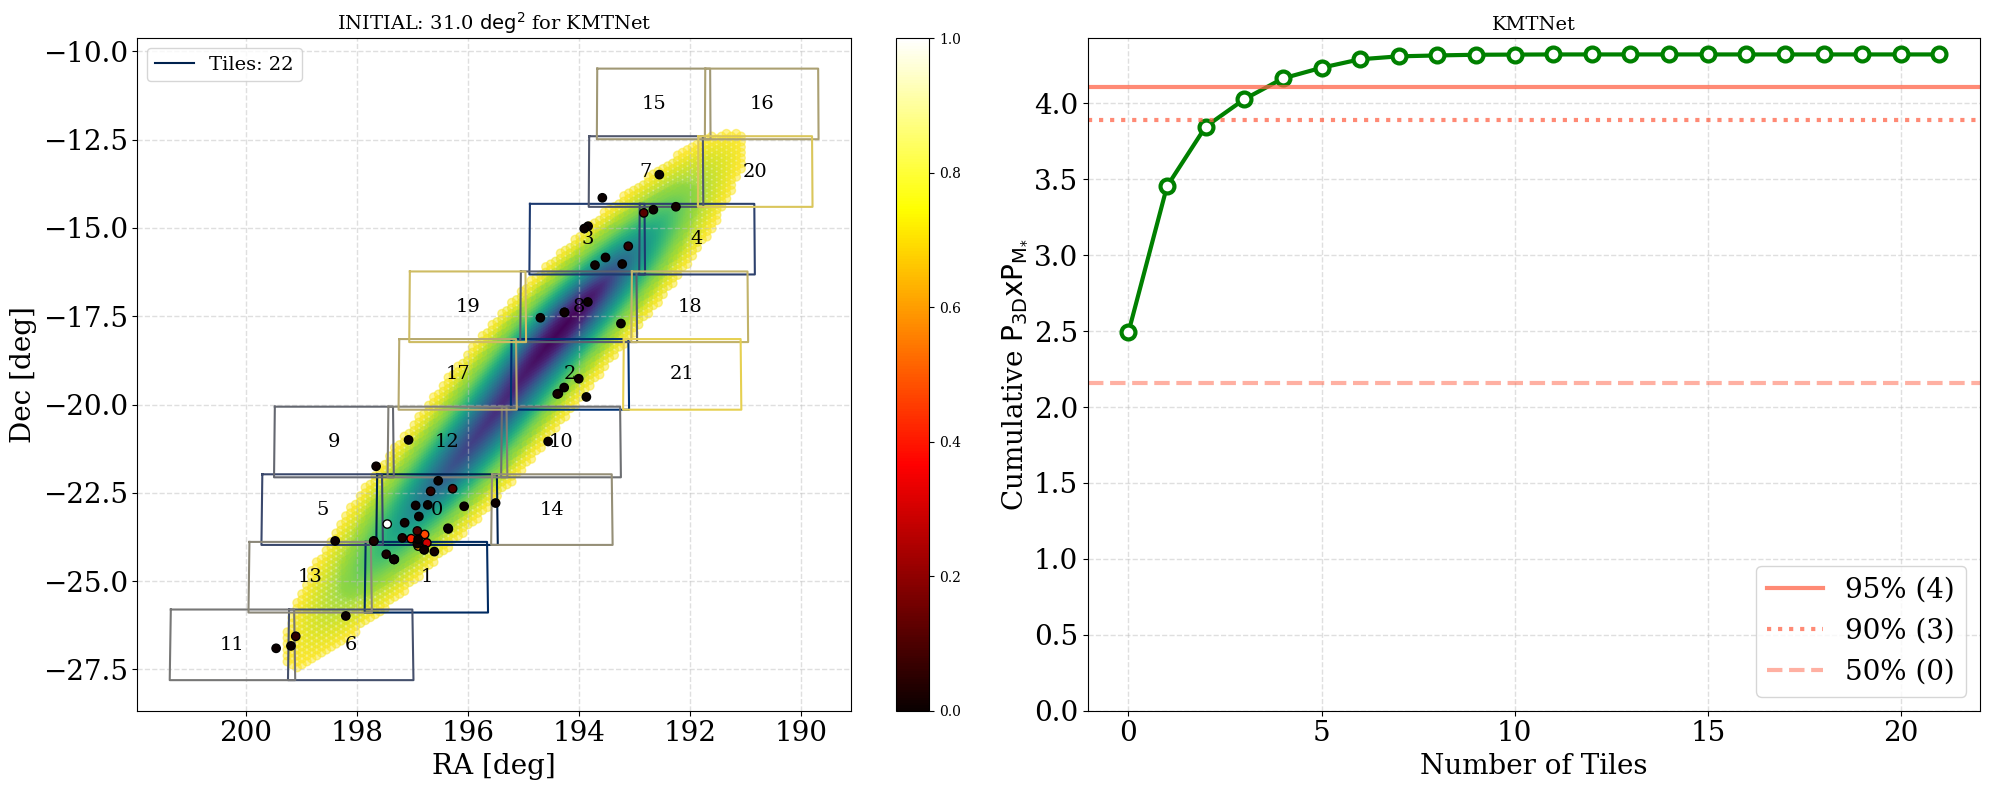

In [27]:
fig = plt.figure(figsize=(20, 8))

title = f"{record['alert_type']}: {area_90.to_value(u.deg**2):.1f} "+r"$\rm deg^2$ "+f"for {obs}"
plt.subplot(121)
plot_tiling_inorder(select_skygrid_cat, simple_galcat, skymap, title=title, only_center=False, probkey=probkey)
xl, xr = plt.xlim()
plt.xlim([xr, xl])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid('both', color='silver', ls='--', lw=1, alpha=0.5)


plt.subplot(122)

# fig = plt.figure(figsize=(10, 8))
plt.plot(cumsum_prob_skygrid, 'o-', mfc='w', mew=3, ms=10, lw=3, c='g')
# include 95%, 99% 
plt.axhline(y=0.95*sum_prob_skygrid, ls='-', c='tomato', lw=3, alpha=0.75, label=f"95% ({len(select_skygrid_cat[select_skygrid_cat['confidence']<=0.95])})")
plt.axhline(y=0.9*sum_prob_skygrid, ls=':', c='tomato', lw=3, alpha=0.75, label=f"90% ({len(select_skygrid_cat[select_skygrid_cat['confidence']<=0.9])})")
plt.axhline(y=0.5*sum_prob_skygrid, ls='--', c='tomato', lw=3, alpha=0.5, label=f"50% ({len(select_skygrid_cat[select_skygrid_cat['confidence']<=0.5])})")

if probkey == 'prob_vol':
    ylabel = r'Cumulative $\rm P_{3D}$'
elif probkey == 'prob_vol_x_stmass':
	ylabel = r'Cumulative $\rm P_{3D}xP_{M_{*}}$'
plt.ylabel(ylabel)
plt.xlabel("Number of Tiles")

yl, yu = plt.ylim()
plt.ylim([0, yu])

plt.legend(loc='lower right', fontsize=20)
# _ = plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid('both', color='silver', ls='--', lw=1, alpha=0.5)
plt.title(f"{obs}")

plt.grid('both', color='silver', ls='--', lw=1, alpha=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.tight_layout()
plt.savefig(f"{path_output}/tiling_{obs}.png", dpi=100)

In [28]:
cat_meta_dict = {
    "obs": obs,
    "alert_type": record['alert_type'],
    "superevent_id": record['superevent_id'],
}
select_skygrid_cat.meta = cat_meta_dict
select_skygrid_cat_name = f"{path_output}/SkyGridCatalog_{obs}_{confidence_limit*1e2:g}.csv"
select_skygrid_cat['obj'] = record['superevent_id']
select_skygrid_cat['note'] = select_skygrid_cat['#id']

skygrid_meta_dict = {
    'superevent_id': record['superevent_id'],
    'alert_type': record['alert_type'],
    'most_probable_event': most_probable_event,
    'most_probable_event_prob': most_probable_event_prob,
    'confidence': confidence_limit,
    'ordering': probkey,
    "obs": obs,
}

select_skygrid_cat.write(f"{select_skygrid_cat_name}", format='csv', overwrite=True)

# 5. Target List & Script Generation

- Tiling Obs.
	- KCT, RASA36, 7DT, KMTNet
	- CBNUO
- Galaxy-targeted Obs.
	- LOAO, SAO, DOAO, KHAO, MDFTS, MAAO
	- LSGT

- Host galaxy candidates

- Import `ObsScheduler` written by HH Choi

In [29]:
import sys
sys.path.append('../observation')
sys.path.append('../observation/Obsscheduler')
from Obsscheduler.obsscheduler import ObsScheduler

New configuration file made : /Users/paek/Research/GECKO/GeckoDigestor/test/../observation/Obsscheduler/config/LOAO/Observer_LOAO.config
New configuration file made : /Users/paek/Research/GECKO/GeckoDigestor/test/../observation/Obsscheduler/config/LOAO/Target_LOAO.config
New configuration file made : /Users/paek/Research/GECKO/GeckoDigestor/test/../observation/Obsscheduler/config/LOAO/Overhead_LOAO.config
New configuration file made : /Users/paek/Research/GECKO/GeckoDigestor/test/../observation/Obsscheduler/config/LOAO/Scheduler_LOAO.config


- Strategies for each telescope

In [30]:
wide_fov_telescopes = [
    # "KMTNet",
    # "7DT",
    "KCT",
    "CBNUO",
    "RASA36",
]
narrow_fov_telescopes = [
    "SAO", # Skip other korean telescopes (e.g. DOAO, KHAO, MDFTS, BOAO, ...)
    "LSGT",
]

print(f"# Wide FOV facilities --> Tiling Strategy ({len(wide_fov_telescopes)})")
for ww, tel in enumerate(wide_fov_telescopes):
    print(f"[{ww}] {tel}")

print(f"# Narrow FOV facilities --> Tiling Strategy ({len(narrow_fov_telescopes)})")
for ww, tel in enumerate(narrow_fov_telescopes):
    print(f"[{ww}] {tel}")

# Wide FOV facilities --> Tiling Strategy (3)
[0] KCT
[1] CBNUO
[2] RASA36
# Narrow FOV facilities --> Tiling Strategy (2)
[0] SAO
[1] LSGT


In [31]:
select_skygrid_cat['weight'] = select_skygrid_cat[probkey]
simple_galcat['weight'] = simple_galcat[probkey]

- Main

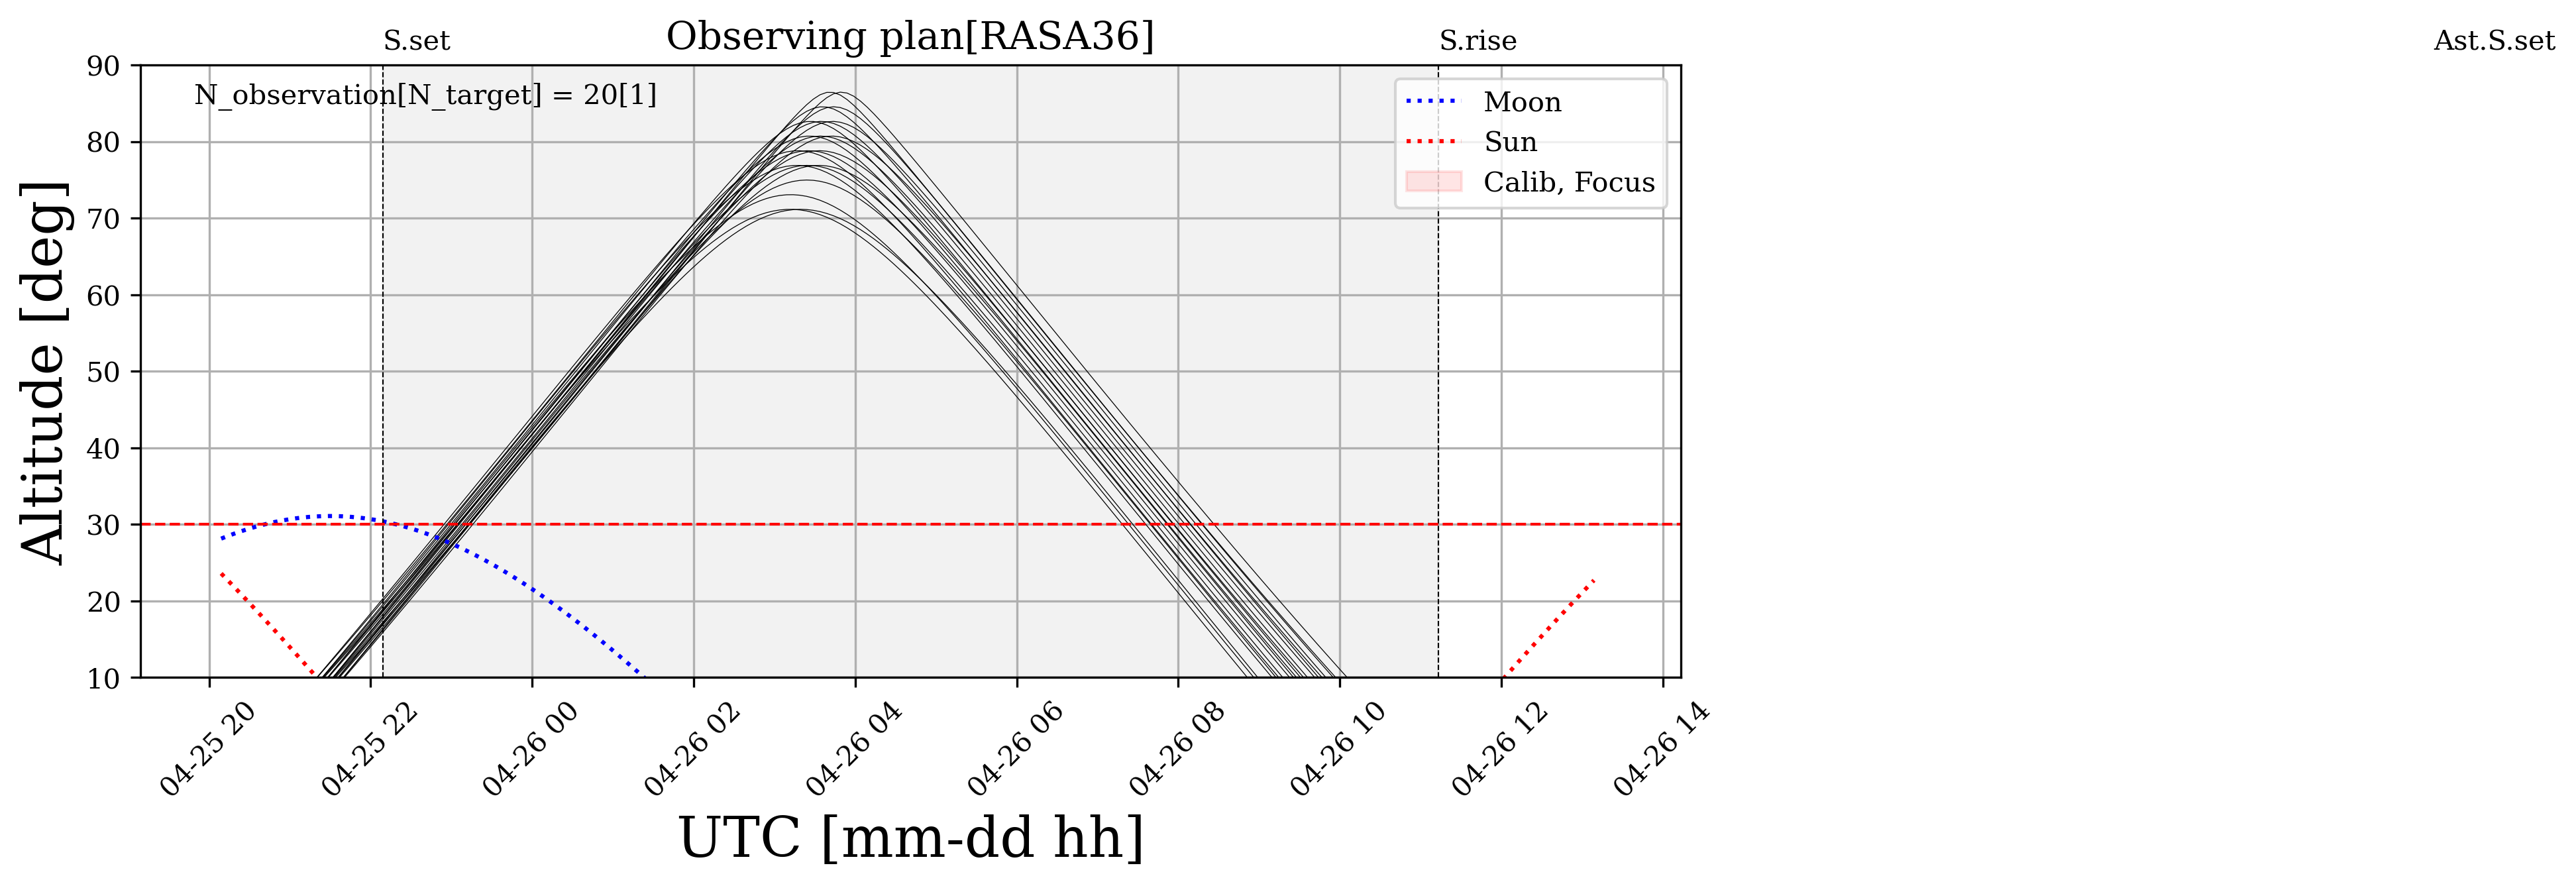

In [32]:
from astropy.io import ascii
from astropy.time import Time

if __name__ == '__main__':
    # from googlesheet import GoogleSheet
    from astropy.io import ascii
    #gs = GoogleSheet()
    #data = gs.get_sheet_data('ToO', format_ ='Table')
    # load table
    
    date = Time.now()
    # date = "20230426"
    # data = '/Users/hhchoi1022/Desktop/SkyGridCatalog_KMTNet_90.csv'
    # data_original = ascii.read(data)
    data_original = select_skygrid_cat
    # data_original.rename_column('prob_vol', 'priority')
    data_original.remove_rows([7, 4])
    #date = Time('2023-05-15T04:36:23', format = 'isot')
    subsequent_days = 1
    file_prefix ='ToO_'
    for i in range(subsequent_days):
        obs = ObsScheduler(target_db = data_original, name_telescope = 'RASA36', entire_night = True, duplicate_when_empty= False, date = date, autofocus_at_init= False)
        obs.write_rts(filename_prefix =file_prefix)
        obs.write_ACPscript_RASA36(filename_prefix =file_prefix) # for RASA36, shutdown = False   
        # obs.write_ACPscript_KCT(filename_prefix =file_prefix, shutdown = True) # for RASA36, shutdown = False
        # obs.write_ACPscript_LSGT(filename_prefix =file_prefix, period_script= 3) # for RASA36, shutdown = False
        logtbl = obs.write_txt(scheduled_only = False, format_ = 'ascii.fixed_width')
        obs.show(save= False, filename_prefix = file_prefix)

# Fin. ALERT!!!

In [33]:
import requests
def slack_bot(token, channel, text):
	response = requests.post("https://slack.com/api/chat.postMessage",
		headers={"Authorization": "Bearer "+token},
		data={"channel": channel,"text": text}
	)
	print(response)
OAuth_Token = SLACK_API_CONFIG['OAuth_Token']

channel = '#gecko--alert'
text = "[GeckoDigestor] I am GECKO-bot. I will let you know that the observation script is ready. Stay tuned!"
#---------------------------------
#       Slack message
#---------------------------------
param_slack = dict(
		token = OAuth_Token,
		channel = channel,
		text = text,
)
# slack_bot(**param_slack)